# 日経平均株価 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'N225'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-21 00:00:00+09:00,40511.550781,40823.320312,40452.191406,40815.660156,157200000,0.0,0.0
2024-03-22 00:00:00+09:00,40942.878906,41087.750000,40714.140625,40888.429688,136100000,0.0,0.0
2024-03-25 00:00:00+09:00,40798.960938,40837.179688,40414.121094,40414.121094,101500000,0.0,0.0
2024-03-26 00:00:00+09:00,40345.039062,40529.531250,40280.851562,40398.031250,101400000,0.0,0.0
2024-03-27 00:00:00+09:00,40517.171875,40979.359375,40452.210938,40762.730469,121300000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-14 00:00:00+09:00,36606.781250,37154.390625,36594.039062,37053.101562,134800000,0.0,0.0
2025-03-17 00:00:00+09:00,37453.828125,37563.269531,37377.550781,37396.519531,120300000,0.0,0.0
2025-03-18 00:00:00+09:00,37868.570312,38004.199219,37822.871094,37845.421875,133500000,0.0,0.0


In [3]:
df0 = ticker.history(period='2y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-03-22 00:00:00+09:00,27298.150391,27520.970703,27267.259766,27466.609375,78100000,0.0,0.0
2023-03-23 00:00:00+09:00,27232.970703,27461.970703,27175.630859,27419.609375,64100000,0.0,0.0
2023-03-24 00:00:00+09:00,27368.619141,27397.289062,27257.439453,27385.250000,59500000,0.0,0.0
2023-03-27 00:00:00+09:00,27482.390625,27543.480469,27359.720703,27476.869141,57400000,0.0,0.0
2023-03-28 00:00:00+09:00,27573.820312,27603.449219,27432.759766,27518.250000,66400000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-14 00:00:00+09:00,36606.781250,37154.390625,36594.039062,37053.101562,134800000,0.0,0.0
2025-03-17 00:00:00+09:00,37453.828125,37563.269531,37377.550781,37396.519531,120300000,0.0,0.0
2025-03-18 00:00:00+09:00,37868.570312,38004.199219,37822.871094,37845.421875,133500000,0.0,0.0


## Moving Median

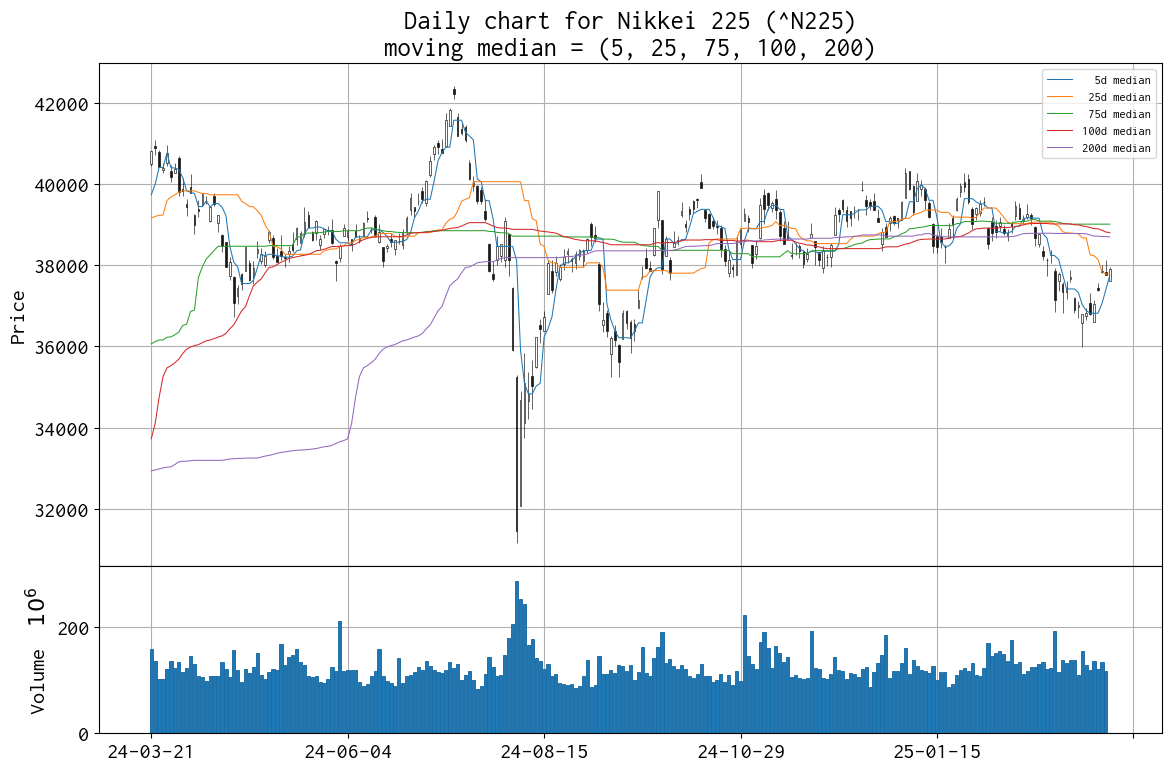

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax[0]),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
ax[0].set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-19 00:00:00+09:00,37839.390625,38128.578125,37751.878906,37751.878906,116800000,0.0,0.0
2025-03-21 00:00:00+09:00,37619.371094,37968.019531,37619.371094,37920.839844,0,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-19 00:00:00+09:00    37751.878906
2025-03-21 00:00:00+09:00    37920.839844
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-19 00:00:00+09:00           NaN
2025-03-21 00:00:00+09:00    168.960938
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-21 00:00:00+09:00    301.46875
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-14 00:00:00+09:00    37028.269531
2025-03-17 00:00:00+09:00    37028.269531
2025-03-18 00:00:00+09:00    37028.269531
2025-03-19 00:00:00+09:00    37028.269531
2025-03-21 00:00:00+09:00    37053.101562
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-14 00:00:00+09:00    37155.500000
2025-03-17 00:00:00+09:00    37155.500000
2025-03-18 00:00:00+09:00    37155.500000
2025-03-19 00:00:00+09:00    37331.179688
2025-03-21 00:00:00+09:00    37331.179688
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-14 00:00:00+09:00    38246.980469
2025-03-17 00:00:00+09:00    38190.080078
2025-03-18 00:00:00+09:00    37993.896484
2025-03-19 00:00:00+09:00    37815.445312
2025-03-21 00:00:00+09:00    37815.445312
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-14 00:00:00+09:00    38933.099609
2025-03-17 00:00:00+09:00    38866.990234
2025-03-18 00:00:00+09:00    38816.326172
2025-03-19 00:00:00+09:00    38799.771484
2025-03-21 00:00:00+09:00    38792.695312
Name: Close, dtype: float64

## Robust Bollinger's bands

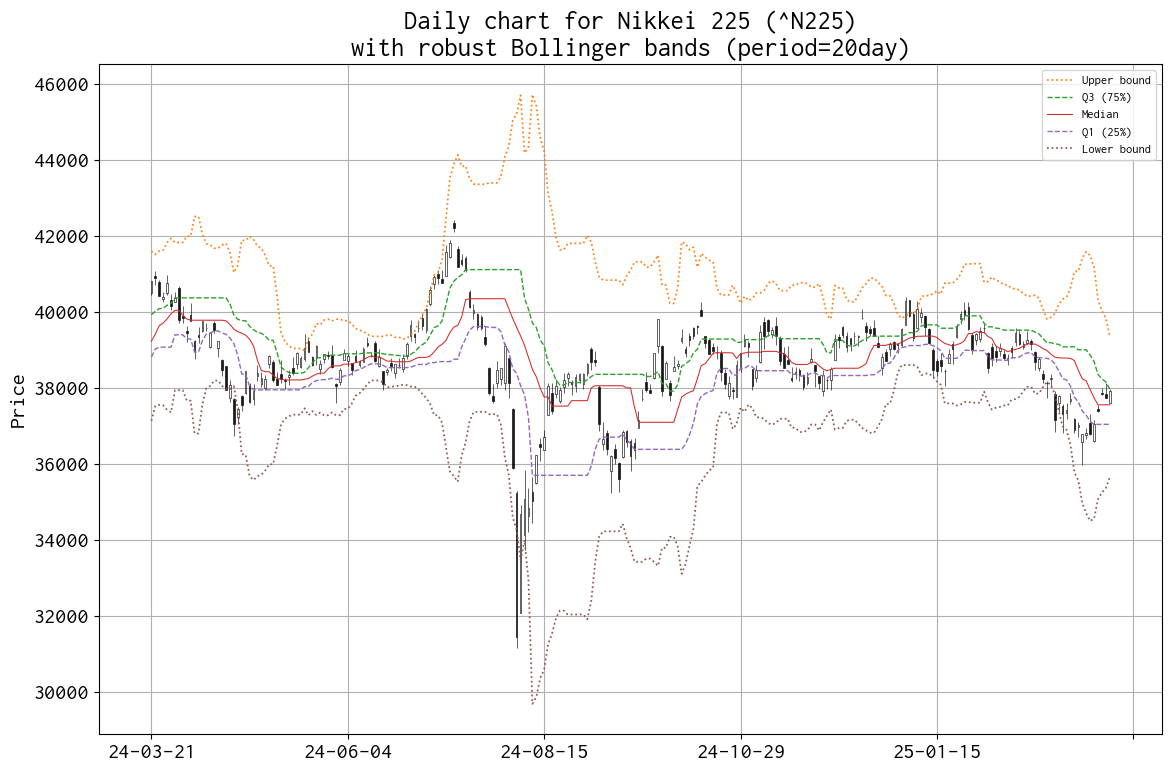

In [15]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

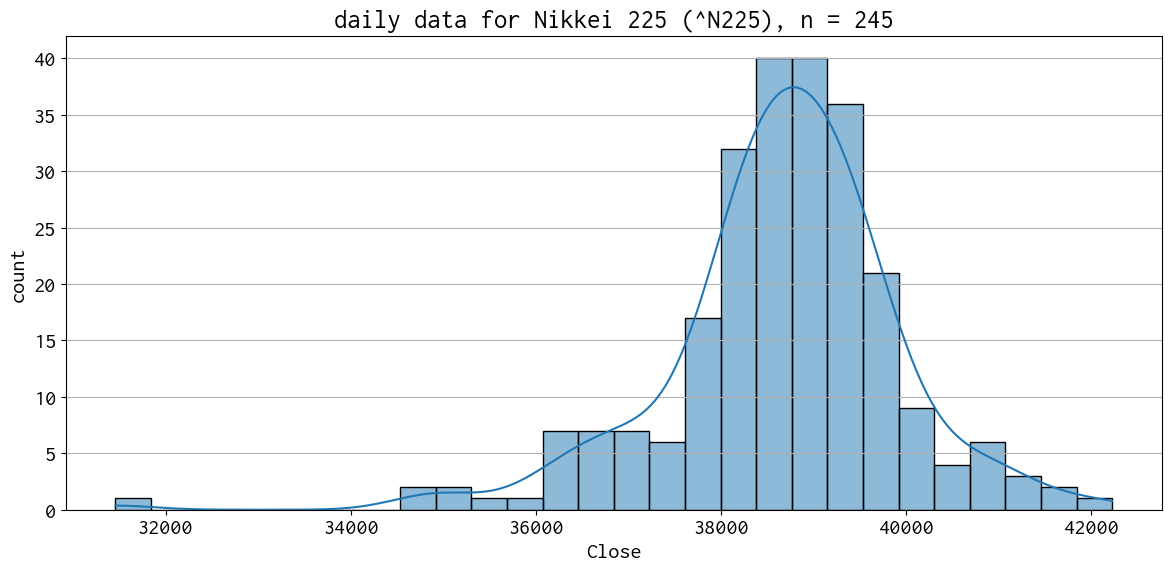

In [14]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 6))
#ax = fig.add_axes(111)
ax = fig.add_subplot(111)

sns.histplot(
    df['Close'],
    kde=True,
    ax=ax
)

ax.set_xlabel("Close")
ax.set_ylabel("count")
ax.set_title('daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)))
ax.grid(axis = 'y')

plt.tight_layout()
plt.savefig('report_daily_histogram_%s.png' % code)
plt.show()